# Stable surface mask from hillshade of reference DEM

In [78]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xrspatial as xrs
import scipy
import os
import skimage
from shapely.geometry import LineString, Polygon

## Load DEM from file

In [32]:
# Load DEM from file
data_path = f'/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/study-sites/{MCS}'
# data_path = f'/Users/rdcrlrka/Research/PhD/SkySat-Stereo/study-sites/{site_name}/'
dem_fn = os.path.join(data_path, 'refdem', 'MCS_REFDEM_WGS84.tif')
dem_da = xr.open_dataarray(dem_fn).squeeze()
dem_ds = xr.open_dataset(dem_fn).squeeze()
dem_ds = dem_ds.rename({'band_data':'elevation'})
dem_ds

<xarray.Dataset> Size: 1GB
Dimensions:      (x: 15747, y: 16810)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 126kB 6.016e+05 6.016e+05 ... 6.094e+05 6.094e+05
  * y            (y) float64 134kB 4.871e+06 4.871e+06 ... 4.862e+06 4.862e+06
    spatial_ref  int64 8B ...
Data variables:
    elevation    (y, x) float32 1GB ...

## Calculate slope and hillshade

In [95]:
# Calculate slope and hillshade
dem_ds['slope'] = xrs.slope(dem_da)
dem_ds['hillshade'] = xrs.hillshade(dem_da, angle_altitude=0)
dem_ds

<xarray.Dataset> Size: 3GB
Dimensions:      (x: 15747, y: 16810)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 126kB 6.016e+05 6.016e+05 ... 6.094e+05 6.094e+05
  * y            (y) float64 134kB 4.871e+06 4.871e+06 ... 4.862e+06 4.862e+06
    spatial_ref  int64 8B ...
Data variables:
    elevation    (y, x) float32 1GB nan nan nan nan nan ... nan nan nan nan nan
    slope        (y, x) float32 1GB nan nan nan nan nan ... nan nan nan nan nan
    hillshade    (y, x) float32 1GB nan nan nan nan nan ... nan nan nan nan nan

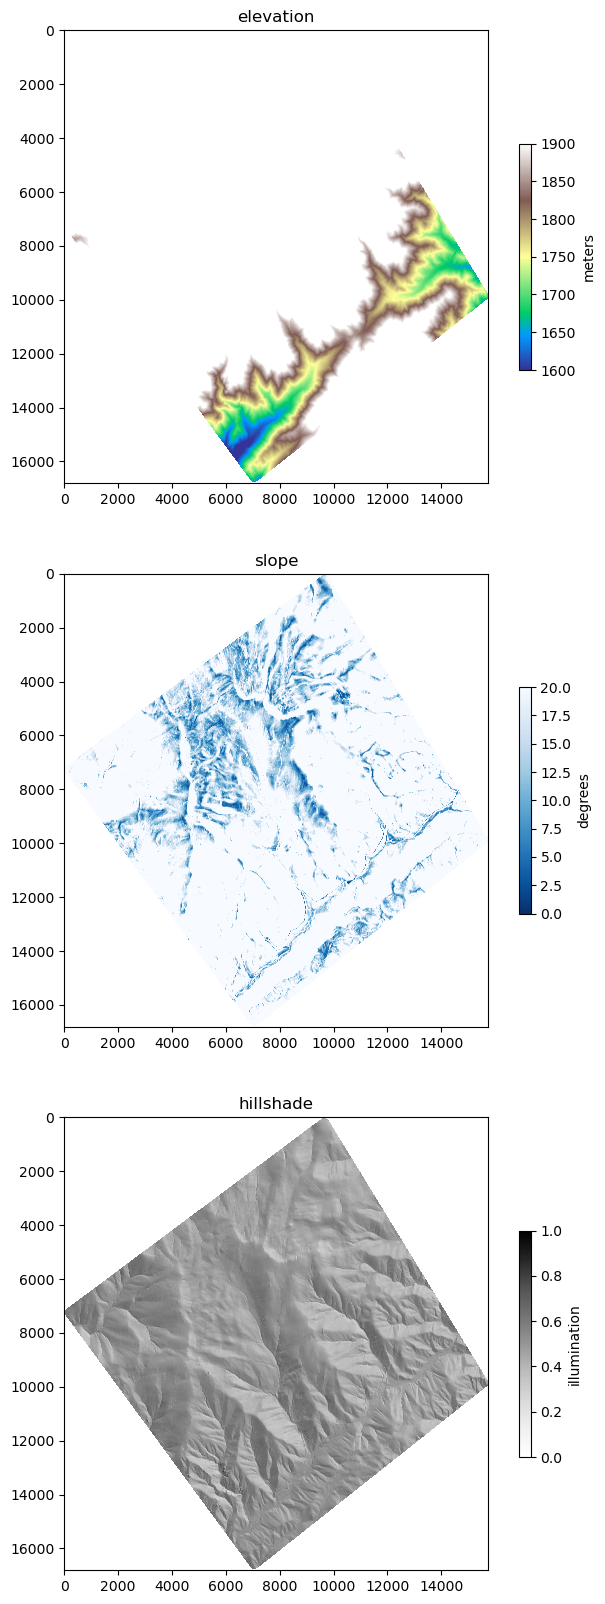

In [97]:
# Plot
fig, ax = plt.subplots(3,1,figsize=(8,20))
units = ['meters', 'degrees', 'illumination']
cmaps = ['terrain', 'Blues_r', 'Greys']
clims = [(1600,1900),
         (0,20),
         (0,1)]
for i, var in enumerate(['elevation', 'slope', 'hillshade']):
    im = ax[i].imshow(dem_ds[var].data, cmap=cmaps[i], clim=clims[i])
    fig.colorbar(im, ax=ax[i], label=units[i], shrink=0.5)
    ax[i].set_title(var)

plt.show()

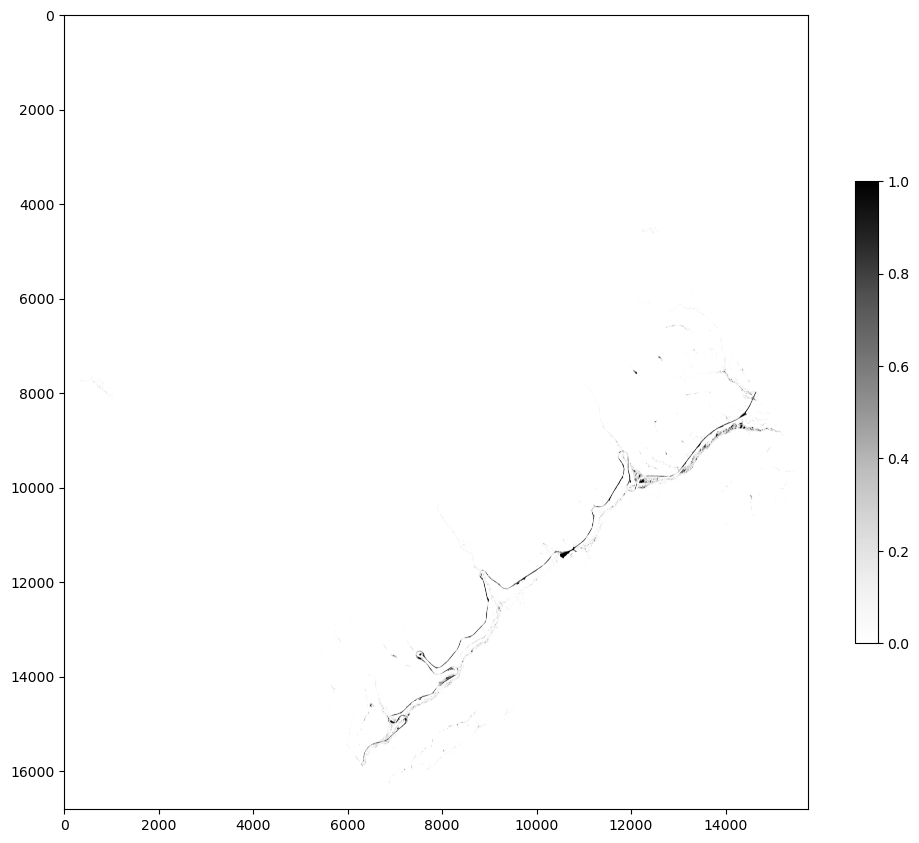

In [98]:
thresh_elev = 1900
thresh_slope = 5
dem_thresh = xr.where((dem_ds['elevation'] < thresh_elev) & (dem_ds['slope'] < thresh_slope), 1, 0)
dem_thresh_filled = scipy.ndimage.binary_fill_holes(dem_thresh.data)
dem_thresh_filled_smoothed = skimage.filters.gaussian(dem_thresh_filled, sigma=5)
plt.figure(figsize=(12,12))
plt.imshow(dem_thresh_filled_smoothed, cmap='Greys')
plt.colorbar(shrink=0.5)
plt.show()

In [99]:
contours = skimage.measure.find_contours(dem_thresh_filled)
print(f'{len(contours)} contours found')


43223 contours found


23 remain after filtering by area


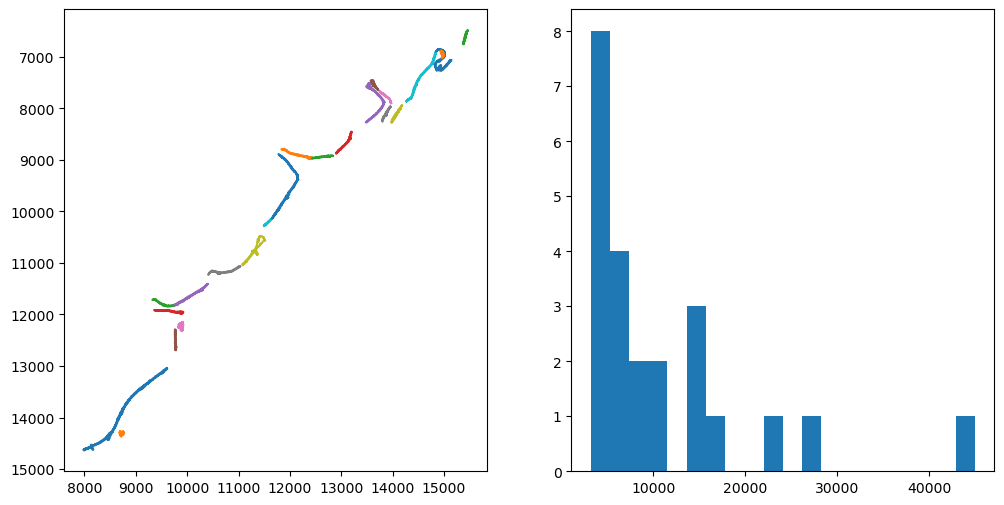

In [102]:
area_thresh = 3e3
polys_list = [Polygon(contour) for contour in contours]
polys_list = [poly for poly in polys_list if poly.area > area_thresh]
poly_areas = np.array([poly.area for poly in polys_list])
print(f'{len(polys_list)} remain after filtering by area')

# length_thresh = 1e3
# lines_list = [LineString(contour) for contour in contours]
# lines_list = [line for line in lines_list if line.length > length_thresh]
# line_lengths = np.array([line.length for line in lines_list])
# print(f'{len(lines_list)} remain after filtering by length')

fig, ax = plt.subplots(1, 2, figsize=(12,6))
for poly in polys_list:
    ax[0].plot(*poly.exterior.coords.xy, '-')
ax[0].invert_yaxis()
ax[1].hist(poly_areas, bins=20)
plt.show()